In [ ]:
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import copy
import matplotlib.pyplot as plt
import os
import time
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc,classification_report,confusion_matrix
import warnings
import random
warnings.filterwarnings('ignore')
from sklearn.svm import SVC


In [ ]:
# y_true = [0,1,2,0,1,2,0,1,2,0,2,1,2,1,2,0,1,1,0,1,2,0,0,0,0,0,1,1,1]
# y_pred = [0,0,1,1,1,1,1,0,0,0,2,2,2,2,1,1,1,1,0,0,0,2,2,2,2,1,1,1,0]
# print(y_true)
# print(y_pred)
# x = list(range(1000))
# y = [i**2 for i in range(1000)]
# plt.figure(figsize=(5,4))
# plt.plot(x,y,label='square')
# plt.legend()
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('test')
# plt.savefig('/content/fig1.svg',format='svg')
# plt.savefig('/content/fig2.png',format='png')
# plt.savefig('/content/fig3.pdf',format='pdf')
# plt.show()

In [ ]:
# print(classification_report(y_true,y_pred))

In [ ]:
# cm = confusion_matrix(y_true,y_pred)
# print(cm)
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print(cm.diagonal())
# # print(roc_auc_score(np.array(labels), np.array(preds)[:,1]))


In [ ]:
#--------------------------------------------------Optimizations-------------------------------------------

from torchvision.transforms.transforms import Resize
config = dict(
    DATA_PATH = "stl10_pytorch/",
    lr = 0.001,
    EPOCHS = 10,
    BATCH_SIZE = 1,
    IMAGE_SIZE = 128,
    pin_memory = True,
    num_workers = 2,
    SEED = 42,
    GPU_ID=0,
)
device = torch.device(f'cuda:{config["GPU_ID"]}' if torch.cuda.is_available() else 'cpu')
print(device)

config['DEVICE'] = device

torch.manual_seed(config['SEED'])
torch.cuda.manual_seed(config['SEED'])


transformations = {
  'general':torchvision.transforms.Compose([
          torchvision.transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
          torchvision.transforms.ToTensor(),
          torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'train':torchvision.transforms.Compose([
          torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'val':torchvision.transforms.Compose([
          torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'test':torchvision.transforms.Compose([
          torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
}

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True


cuda:0


In [ ]:
#--------------------------------------------------LoadData-------------------------------------------
# get the dataset
traindata = torchvision.datasets.STL10(root=config['DATA_PATH'],split='train',download=True,transform = transformations['general'])
testdata = torchvision.datasets.STL10(root=config['DATA_PATH'],split='test',download=True,transform = transformations['general'])
print('train samples -> ',len(traindata))
print('test samples ->', len(testdata))


train_loader = torch.utils.data.DataLoader(dataset=traindata,batch_size=config['BATCH_SIZE'],shuffle=True,num_workers=config['num_workers'],pin_memory=config['pin_memory'])
test_loader = torch.utils.data.DataLoader(dataset=testdata,batch_size=config['BATCH_SIZE'],shuffle=True,num_workers=config['num_workers'],pin_memory=config['pin_memory'])

# data,target = next(iter(train_loader))
# print(target)

# plt.imshow(data[0][0])
# plt.savefig('visual_curves/seeimg.svg',format='svg')

Files already downloaded and verified
Files already downloaded and verified
train samples ->  5000
test samples -> 8000


In [ ]:
#----------------------------------------------------Make model------------------------------

resnet = torchvision.models.resnet50(pretrained=True)
resnet.fc = nn.Sequential()
resnet = resnet.to(config['DEVICE'])

def extract_features(model,loader):
    x_train = []
    y_train = []
    for idx,(data,target) in enumerate(loader):
        data = data.to(config['DEVICE'])
        # target = target.to(config['DEVICE'])
        
        features = model(data)
        features = features.flatten(start_dim=0)
        features= features.cpu()
        features = np.array(list(map(lambda x:x.item(),features)))
        x_train.append(features)
        y_train.append(target.item())
        print(f'done {idx}',end='\r')
        
    return x_train,y_train

def find_accuracy(y_test,predicted_prob):
    accuracy = 0
    y_test = np.array(y_test)
    classes = np.argmax(predicted_prob,axis=1)
    accuracy += (y_test == classes).sum()
    return accuracy/len(y_test)

def confusion_mat(y_true,predicted_prob):
  y_pred = np.argmax(predicted_prob,axis=1)
  y_true = np.array(y_true)

  values,unique = np.unique(y_true,return_counts=True)
  cm = np.zeros((len(values),len(values)))
  for idx,t in enumerate(y_true):
    p = y_pred[idx]
    cm[t][int(p)] += 1
  return cm

def measures(y_true,y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  unique_values = np.unique(y_true)
  cm = np.zeros((len(unique_values),len(unique_values)))
  for i in range(len(y_true)):
    t = y_true[i]
    p = y_pred[i]
    cm[int(t)][int(p)] += 1
  measure = np.divide(cm.T,np.sum(cm,axis=1)).T
  return measure[0][1],measure[1][1]
# print(measures([0,1,1,1,0,0,1,1,0],
#                [1,0,1,1,0,0,1,1,1]))
def get_fpr_tpr(ytrue_onehot,prob):
  partitions = 100
  fpr_arr = []
  tpr_arr = []
  for i in range(partitions+1):
    th_pred = np.greater_equal(prob,i/partitions).astype(np.int32)
    fpr,tpr = measures(ytrue_onehot,th_pred)
    fpr_arr.append(fpr)
    tpr_arr.append(tpr)
  return fpr_arr,tpr_arr

def roc(y_true,predicted_prob):
  y_true = np.array(y_true)
  unique_values = np.unique(y_true)
  onehot_ytrue = np.zeros((len(y_true),len(unique_values)))
  for idx,value in enumerate(y_true):
    onehot_ytrue[idx][int(value)] = 1

  fpr_tpr = {}
  for i in range(len(unique_values)):
    fpr,tpr = get_fpr_tpr(onehot_ytrue[:,i],predicted_prob[:,i])
    fpr_tpr[i] = [fpr,tpr]

  plt.figure(figsize=(5,4))  
  for i in range(len(unique_values)):
    fpr,tpr = fpr_tpr[i]
    plt.plot(fpr,tpr,label=f'class:{i}')

  plt.xlabel('fpr')
  plt.ylabel('tpr')
  plt.title('ROC')
  plt.legend()
  plt.savefig('/content/ROC_que2.svg',format='svg')
  plt.show()
  
# predicted_prob = np.random.rand(100,3)
# y_true = [random.choice([0,1,2]) for i in range(100)]

# roc(y_true,predicted_prob)

# rrr = roc([0,1,2,0,2,1],2)
# def findroc(y_test,predicted_prob):
#     pass


In [ ]:
x_train,y_train = extract_features(resnet,train_loader)

In [ ]:
mysvm = SVC(C=3,probability=True,decision_function_shape='ovr')
mysvm.fit(x_train,y_train)

SVC(C=3, probability=True)

In [ ]:
x_test,y_test = extract_features(resnet,test_loader)

In [ ]:
predicted_prob = mysvm.predict_proba(x_test)

In [ ]:
acc = find_accuracy(y_test,predicted_prob)
print(acc)

0.697625


In [ ]:
confusion_mat(y_test,predicted_prob)

array([[609.,  26.,  20.,  13.,   5.,   5.,   9.,   6.,  68.,  39.],
       [ 30., 582.,   1.,  55.,  20.,  27.,  16.,  61.,   5.,   3.],
       [ 15.,   3., 654.,   5.,   2.,   4.,   1.,   3.,  20.,  93.],
       [ 16.,  43.,   5., 465.,  62.,  84.,  34.,  62.,  19.,  10.],
       [ 14.,  33.,   4.,  49., 550.,  46.,  67.,  28.,   6.,   3.],
       [ 11.,  24.,   3.,  83.,  49., 454.,  87.,  76.,   7.,   6.],
       [ 14.,  27.,   3.,  32.,  66.,  82., 536.,  25.,   6.,   9.],
       [  8.,  53.,   4.,  58.,  30.,  51.,  28., 559.,   4.,   5.],
       [ 68.,   5.,  17.,  11.,   3.,   8.,   3.,   4., 608.,  73.],
       [ 45.,   5.,  83.,  13.,   1.,   4.,   1.,   5.,  79., 564.]])

In [ ]:
print('using inbuilt')
confusion_matrix(y_test,np.argmax(predicted_prob,axis=1))

using inbuilt


array([[609,  26,  20,  13,   5,   5,   9,   6,  68,  39],
       [ 30, 582,   1,  55,  20,  27,  16,  61,   5,   3],
       [ 15,   3, 654,   5,   2,   4,   1,   3,  20,  93],
       [ 16,  43,   5, 465,  62,  84,  34,  62,  19,  10],
       [ 14,  33,   4,  49, 550,  46,  67,  28,   6,   3],
       [ 11,  24,   3,  83,  49, 454,  87,  76,   7,   6],
       [ 14,  27,   3,  32,  66,  82, 536,  25,   6,   9],
       [  8,  53,   4,  58,  30,  51,  28, 559,   4,   5],
       [ 68,   5,  17,  11,   3,   8,   3,   4, 608,  73],
       [ 45,   5,  83,  13,   1,   4,   1,   5,  79, 564]])

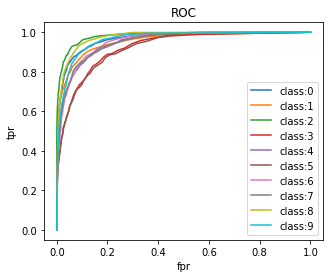

In [ ]:
roc(y_test,predicted_prob)